# Prompt

## Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

## The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals.  

From the dataset documentation [here](https://www.openml.org/d/534):

> The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership.

## Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

# Imports

In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import (
    make_column_transformer,
    TransformedTargetRegressor,
    make_column_selector,
)
from sklearn.utils import Bunch
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import fetch_openml
from sklearn.metrics import (
    mean_squared_error,
    PredictionErrorDisplay,
    median_absolute_error,
    r2_score,
)

from IPython.display import Image

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [3]:
df = fetch_openml(data_id=534, as_frame=True).frame

In [4]:
df = df.query("WAGE > 1 and WAGE < 30")  # snip 2 outliers

In [5]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


# Feature Naming

In [6]:
target_feature = "WAGE"
numeric_features = df.columns[df.dtypes != "category"].to_list()
numeric_features.remove(target_feature)
one_hot_features = df.columns[df.dtypes == "category"].to_list()
display([numeric_features, one_hot_features])

[['EDUCATION', 'EXPERIENCE', 'AGE'],
 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']]

# Assign to Feature and Target Frames

In [7]:
X = df.drop(columns=target_feature)
y = df[target_feature]

In [8]:
# X.head()

# Develop Processing Pipeline

## Polynomial Features

In [9]:
poly_pipe = Pipeline(
    [
        (
            "scaler",
            make_column_transformer(
                (
                    StandardScaler(),
                    numeric_features,
                ),
            ),
        ),
        ("poly", PolynomialFeatures(include_bias=False)),
    ]
)

poly_pipe

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('poly', PolynomialFeatures(include_bias=False))])

In [10]:
# poly_pipe.fit(X)
# pd.DataFrame(
#     poly_pipe.transform(X), columns=poly_pipe.get_feature_names_out()
# )

## One Hot Features

In [11]:
ohe_pipe = Pipeline(
    [
        (
            "ohe",
            make_column_transformer(
                (
                    OneHotEncoder(drop="if_binary"),
                    # make_column_selector(dtype_include="category"), # works, but prefer explicit control
                    one_hot_features,
                ),
            ),
        ),
    ]
)

ohe_pipe

Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])]))])

In [12]:
# ohe_pipe.fit(X)
# pd.DataFrame(ohe_pipe.transform(X), columns=ohe_pipe.get_feature_names_out())

## Union of Features

In [13]:
feature_union = FeatureUnion(
    [
        ("poly_pipe", poly_pipe),
        ("ohe_pipe", ohe_pipe),
    ]
)

feature_union

FeatureUnion(transformer_list=[('poly_pipe',
                                Pipeline(steps=[('scaler',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['EDUCATION',
                                                                                   'EXPERIENCE',
                                                                                   'AGE'])])),
                                                ('poly',
                                                 PolynomialFeatures(include_bias=False))])),
                               ('ohe_pipe',
                                Pipeline(steps=[('ohe',
                                                 ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(drop='if_binary'),
                                                                                  ['SOUTH',
                                                                                   'SEX',
                                                                                   'UNION',
                                                                                   'RACE',
                                                                                   'OCCUPATION',
                                                                                   'SECTOR',
                                                                                   'MARR'])]))]))])

In [14]:
# feature_union.fit(X)
# pd.DataFrame(
#     feature_union.transform(X), columns=feature_union.get_feature_names_out()
# )

## Ridge Pipeline

In [15]:
ridge_pipe = Pipeline(
    [
        ("feature_union", feature_union),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(fit_intercept=True)),
    ]
)

ridge_pipe

Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('poly_pipe',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('standardscaler',
                                                                                                   StandardScaler(),
                                                                                                   ['EDUCATION',
                                                                                                    'EXPERIENCE',
                                                                                                    'AGE'])])),
                                                                 ('poly',
                                                                  PolynomialFeatures(include_bias=False))])),
                                                ('ohe_pipe',
                                                 Pipeline(steps=[('ohe',
                                                                  ColumnTransformer(transformers=[('onehotencoder',
                                                                                                   OneHotEncoder(drop='if_binary'),
                                                                                                   ['SOUTH',
                                                                                                    'SEX',
                                                                                                    'UNION',
                                                                                                    'RACE',
                                                                                                    'OCCUPATION',
                                                                                                    'SECTOR',
                                                                                                    'MARR'])]))]))])),
                ('scaler', StandardScaler()), ('ridge', Ridge())])

## Transformed Target Regression

To verify that TTR is doing what we want
- Replace both func and inverse func with an identity function  
    - `func=lambda x: x, inverse_func=lambda x: x`
- Perform the fit on log of y
    - `fit(X, np.log(y))`
- And take the inverse of log (exp) of the prediction
    - `y_pred = np.exp(ttr_pipe.predict(X))`

In [16]:
ttr_pipe = Pipeline(
    [
        (
            "ttr",
            TransformedTargetRegressor(
                regressor=ridge_pipe,
                func=np.log,
                inverse_func=np.exp,
                # func=lambda x: x, inverse_func=lambda x: x,
            ),
        )
    ]
)  # .fit(X, y)
# ).fit(X, np.log(y))

# mean_squared_error(ttr_pipe.predict(X), y)  # 16.380011621106625
# mean_squared_error(np.exp(ttr_pipe.predict(X)), y)

# ttr_pipe

# Grid Search over Hyperparameters

In [17]:
(train_inds, dev_inds) = train_test_split(
    range(len(df)), random_state=42, train_size=0.75
)

In [18]:
# list(ttr_pipe.get_params().keys())  # to see parameter names
# ttr_pipe.get_params()  # to see parameter names and values

In [19]:
# param_grid = {
#     "ttr__regressor__feature_union__poly_pipe__poly__degree": range(1, 2),
#     "ttr__regressor__ridge__alpha": np.array([1.0]),
# }

In [20]:
param_grid = {
    "ttr__regressor__feature_union__poly_pipe__poly__degree": range(1, 4),
    "ttr__regressor__ridge__alpha": 10 ** np.linspace(-5, 5, 51),
}

In [21]:
grid_search = GridSearchCV(
    estimator=ttr_pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(X, y)

In [22]:
grid_search.best_params_

{'ttr__regressor__feature_union__poly_pipe__poly__degree': 3,
 'ttr__regressor__ridge__alpha': 158.48931924611142}

In [23]:
ttr_pipe_best = grid_search.best_estimator_.fit(X, y)
ttr_pipe_best

Pipeline(steps=[('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Pipeline(steps=[('feature_union',
                                                                       FeatureUnion(transformer_list=[('poly_pipe',
                                                                                                       Pipeline(steps=[('scaler',
                                                                                                                        ColumnTransformer(transformers=[('standardscaler',
                                                                                                                                                         StandardScaler(),
                                                                                                                                                         ['EDUCATION',
                                                                                                                                                          'EXPERIENCE',
                                                                                                                                                          'AGE'])])),
                                                                                                                       ('poly',
                                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                                           include_bias=False))])),
                                                                                                      ('ohe_pipe',
                                                                                                       Pipeline(steps=[('ohe',
                                                                                                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                                         OneHotEncoder(drop='if_binary'),
                                                                                                                                                         ['SOUTH',
                                                                                                                                                          'SEX',
                                                                                                                                                          'UNION',
                                                                                                                                                          'RACE',
                                                                                                                                                          'OCCUPATION',
                                                                                                                                                          'SECTOR',
                                                                                                                                                          'MARR'])]))]))])),
                                                                      ('scaler',
                                                                       StandardScaler()),
                                                                      ('ridge',
                                                                       Ridge(alpha=158.48931924611142))])))])

# Plot of Model Error vs. Parameters

In [24]:
results_df = pd.DataFrame(grid_search.cv_results_["params"]).join(
    pd.DataFrame({"mean_test_score": grid_search.cv_results_["mean_test_score"]})
)

# Simplify the parameter names to the last __value
results_df.columns = [name.split("__")[-1] for name in results_df.columns]
results_df

,degree,alpha,mean_test_score
0,1,0.000010,-21.064891
1,1,0.000016,-21.064889
2,1,0.000025,-21.064886
3,1,0.000040,-21.064880
4,1,0.000063,-21.064872
...,...,...,...
148,3,15848.931925,-24.634460
149,3,25118.864315,-24.852946
150,3,39810.717055,-24.999762
151,3,63095.734448,-25.096347


In [25]:
best_poly_degree = list(grid_search.best_params_.values())[0]
best_alpha = list(grid_search.best_params_.values())[1]

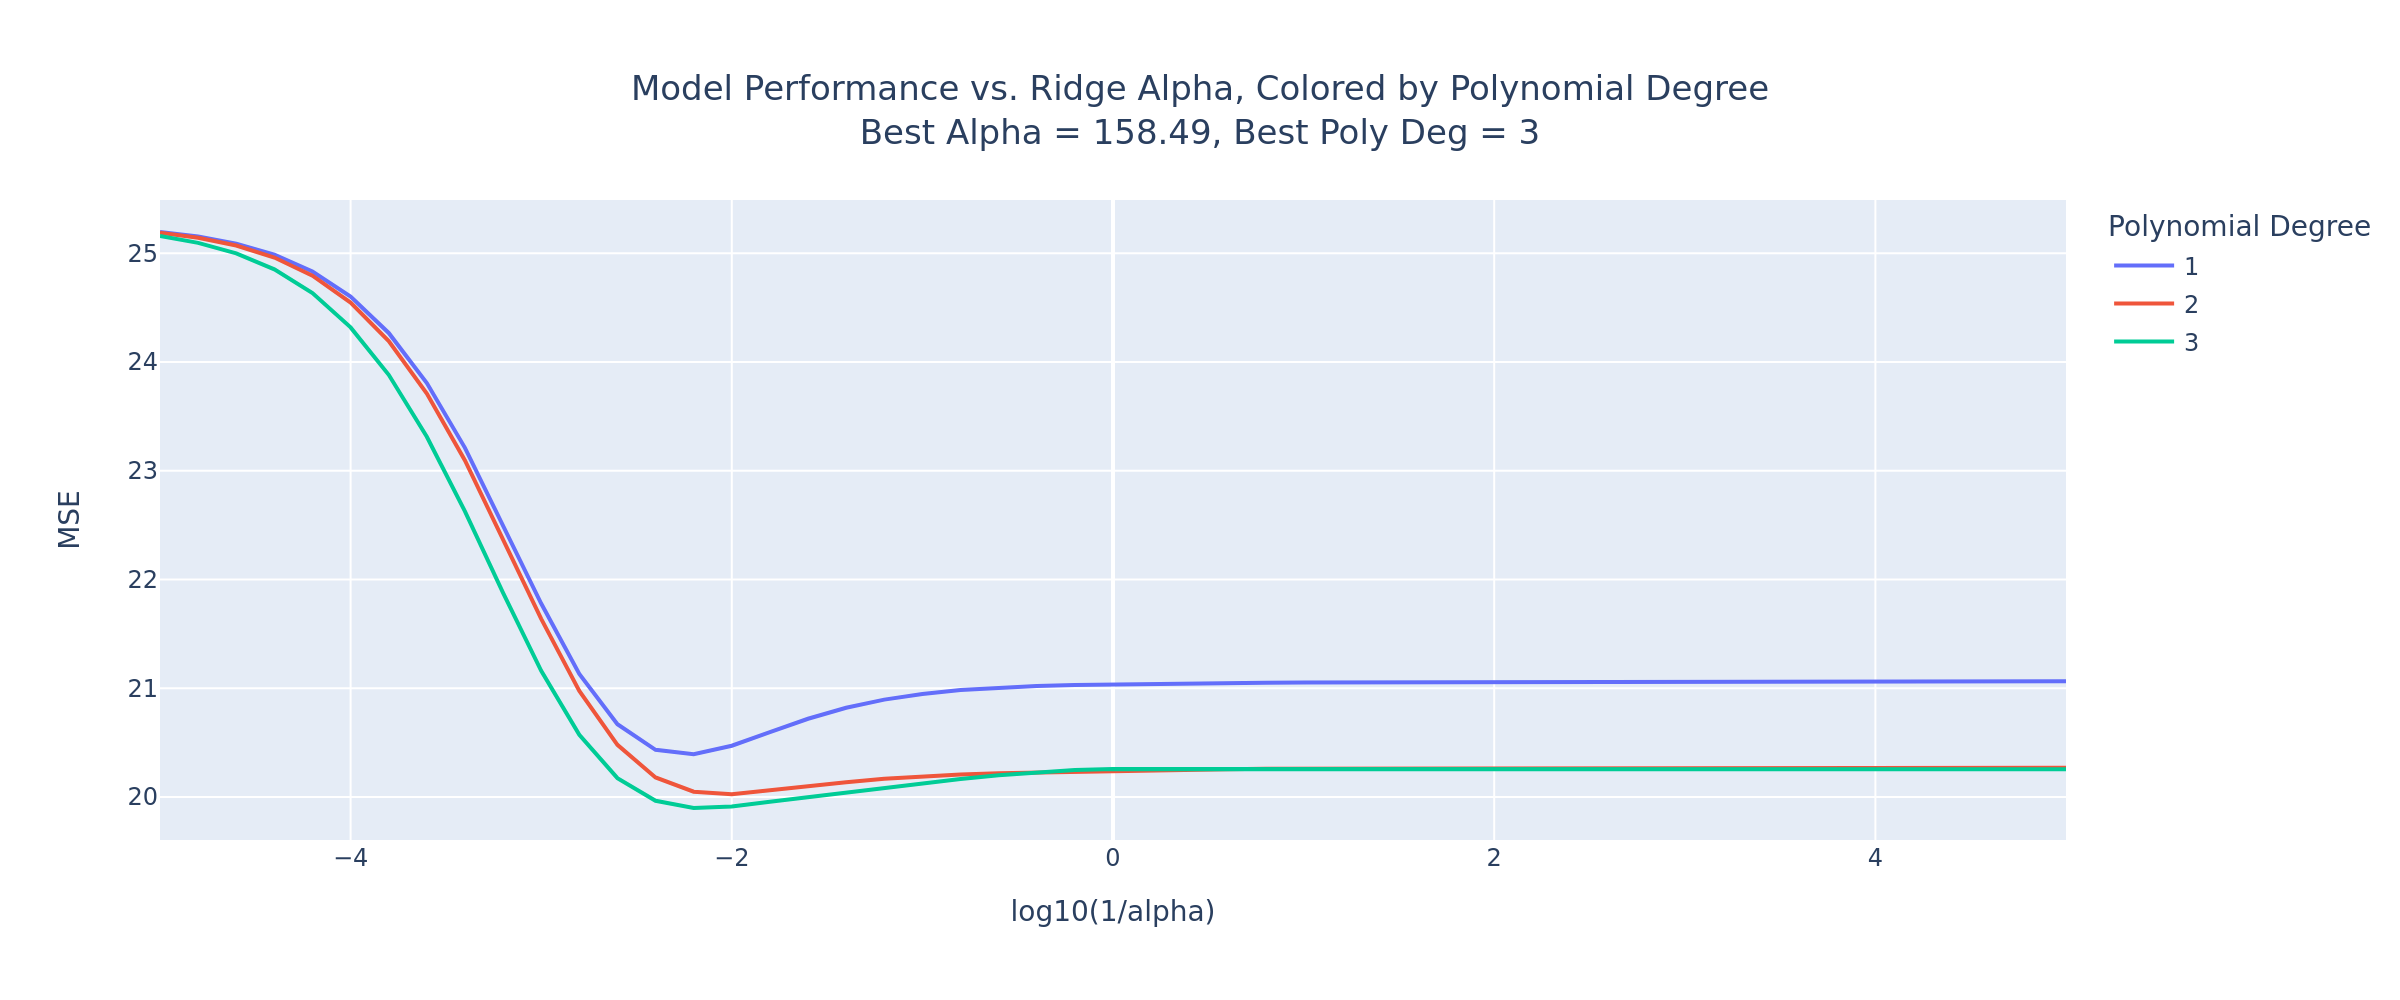

In [26]:
fig = px.line(
    results_df,
    x=np.log10(1.0 / results_df["alpha"]),
    y=-results_df["mean_test_score"],
    labels={
        "x": "log10(1/alpha)",
        "y": "MSE",
        "degree": "Polynomial Degree",
    },
    title="Model Performance vs. Ridge Alpha, Colored by Polynomial Degree<br>Best Alpha = %.2f, Best Poly Deg = %d"
    % (best_alpha, best_poly_degree),
    color="degree",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

# Plots of Predicted vs. Truth Data

## Compute predictions using the default and optimized pipeline

In [36]:
y_pred = ttr_pipe_best.predict(X)

In [37]:
mse_best = mean_squared_error(y, y_pred)  # 15.740574797249632
mse_best

15.740574797249632

## Use PredictionErrorDisplay

In [38]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
        "MSE": f"{mean_squared_error(y_true, y_pred):.3f}",
    }

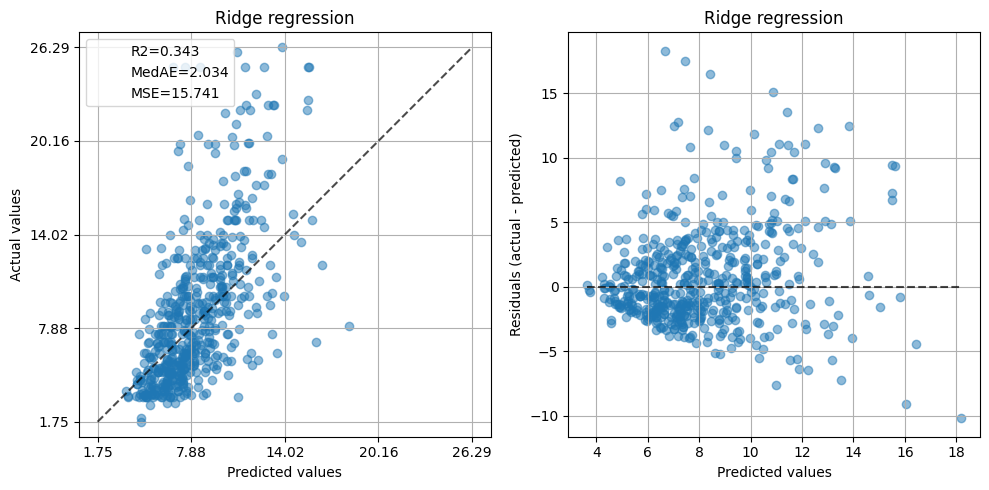

In [39]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# plot the actual vs predicted values
PredictionErrorDisplay.from_predictions(
    y,
    y_pred,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)

ax0.set_title("Ridge regression")

# Add the score in the legend of each axis
for name, score in compute_score(y, y_pred).items():
    ax0.plot([], [], " ", label=f"{name}={score}")
ax0.legend(loc="upper left")

# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y,
    y_pred,
    kind="residual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

ax1.set_title("Ridge regression")

plt.tight_layout()
plt.show()

# Permutation Importance

In [31]:
def make_permutation_importance_DataFrame(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    permutation_importance_kwargs: dict,
) -> pd.DataFrame:
    # Compute the importances
    pi = permutation_importance(
        model,
        X,
        y,
        **permutation_importance_kwargs,
    )

    # Make frame from the importances, with columns arranged from
    # lowest to highest mean importance
    ordered_features = list(np.array(X.columns)[np.argsort(pi.importances_mean)])
    return pd.DataFrame(pi.importances.T, columns=X.columns)[ordered_features]

In [32]:
# Importance per feature
df_pi = make_permutation_importance_DataFrame(
    ttr_pipe_best,
    X,
    y,
    {"random_state": 42, "n_repeats": 100},
)

df_pi.head()

,MARR,SOUTH,RACE,SECTOR,EXPERIENCE,UNION,AGE,SEX,OCCUPATION,EDUCATION
0,-0.000404,0.011680,0.009831,0.016776,0.012199,0.024830,0.044666,0.050747,0.104885,0.138356
1,0.004758,0.007828,0.009335,0.025286,0.019870,0.031346,0.058988,0.078976,0.103046,0.141890
2,0.004029,0.003894,0.001824,0.011203,0.004856,0.015565,0.027642,0.084515,0.114114,0.127667
3,0.002639,0.007407,0.011654,0.009620,0.013659,0.009345,0.041285,0.064387,0.122683,0.130200
4,0.004703,0.007343,0.010657,0.001027,0.008763,0.027561,0.039957,0.075540,0.124425,0.142152


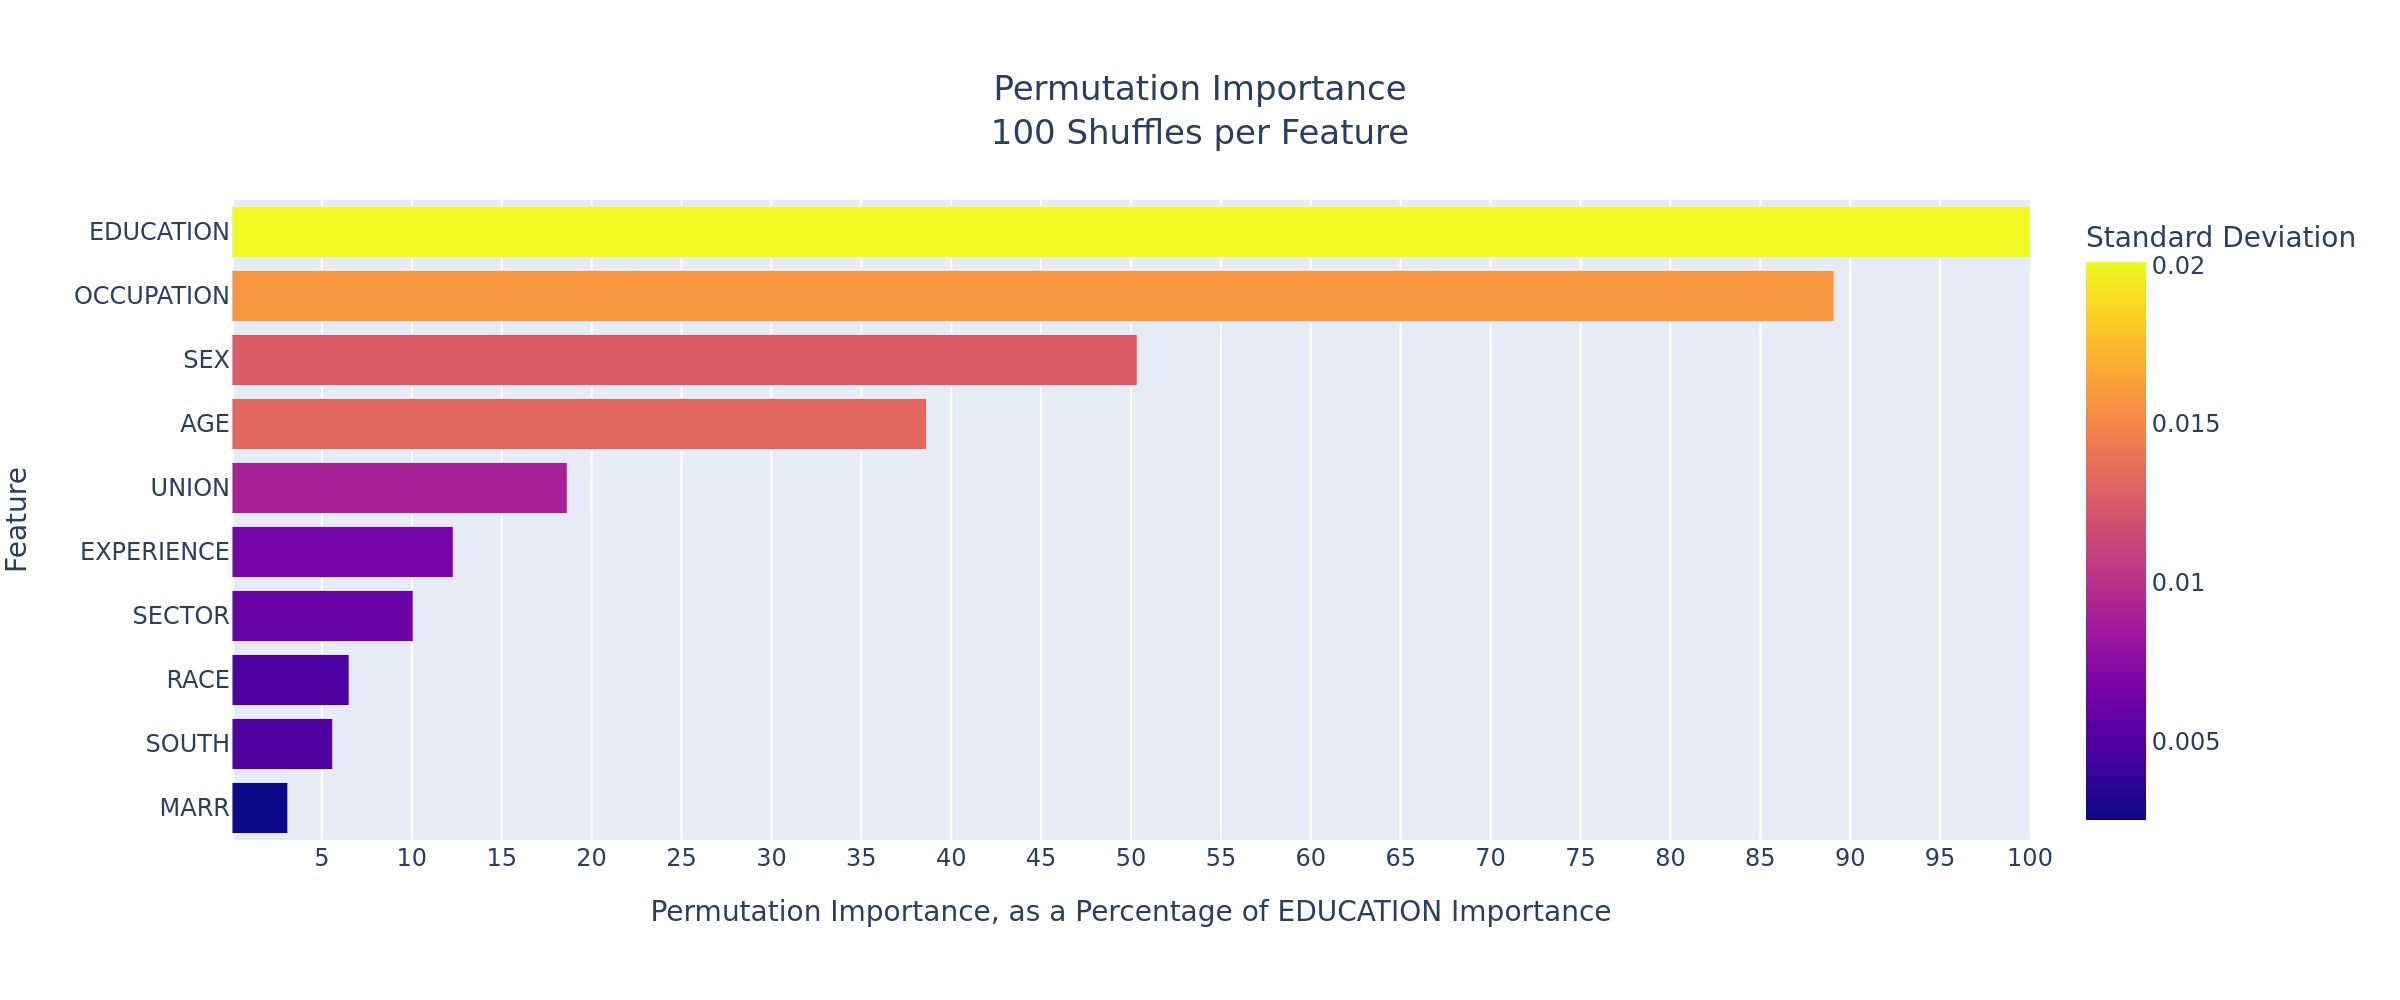

In [33]:
Image(
    px.bar(
        data_frame=df_pi.mean() / df_pi.mean()[-1] * 100.0,
        color=df_pi.std(),
        orientation="h",
        title="Permutation Importance<br>%d Shuffles per Feature" % len(df_pi),
        labels={
            "value": "Permutation Importance, as a Percentage of %s Importance"
            % df_pi.columns[-1],
            "index": "Feature",
            "color": "Standard Deviation",
        },
    )
    .update_layout(title_x=0.5)
    .update_xaxes(tickvals=list(range(5, 105, 5)), range=[0, 100])
    .to_image(format="png", width=1200, scale=2)
)